## Первый блок - подготовка данных. 
###  Этот код загружает данные из CSV-файла, выбирает необходимые столбцы и переименовывает их (нужно указать актуальные названия столбцов). Затем происходит группировка данных по идентификатору проекта и выбор только тех проектов, у которых 4 или 5 этапов. Далее происходит преобразование групп в массив массивов индексов строк и изменение значения столбца 'stage' для каждой строки в зависимости от номера этапа (от 0 до 4 соответственно). 

### В конце можно увидеть пример: выводим i-й проект по этапам 

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import re
warnings.filterwarnings('ignore')

df = pd.read_csv("/Users/antonnuzhdin/Downloads/Управление_проектами_2023_05_16T00_01_22+0300.csv")

data_project = df

data_project = data_project[['Тема', 'Пользовательское поле (PI (План))','Пользовательское поле (PI (Факт))', 'Пользовательское поле (Ключ проекта)', 'Пользовательское поле (End date)', 'Тип задачи']]
data_project = data_project.rename(columns={'Пользовательское поле (PI (План))': 'TPM', 'Пользовательское поле (PI (Факт))': 'TSM',
                                           'Пользовательское поле (Ключ проекта)': 'key',
                                           'Пользовательское поле (End date)': 'end date',
                                           'Тип задачи': 'Тип'})


# группировка по идентификатору проекта
grouped = data_project[data_project['Тип'] == 'Этап'].groupby(data_project['key'])

# преобразование групп в массив массивов индексов строк
# выбираем только проекты у которых 4-5 этапов. Все остальное - мусор
pos = [group[1].index.tolist() for group in grouped if len(group[1].index.tolist()) in {4, 5}]

    
for x in pos:
    x.reverse()
    
data_project['stage'] = 1
for lines in pos:
    if len(lines) == 4:
        for i in range(1, 5):
            data_project.at[lines[i - 1], 'stage'] = i - 1
    else:
        for i in range(1, 6):
            data_project.at[lines[i - 1], 'stage'] = i - 1
            


            
data_project.iloc[pos[0]]

,Тема,TPM,TSM,key,end date,Тип,stage
14573,BDBI-161: 01.Инициация Разработка функциональн...,84.0,0.0,BDBI-161,02.09.2022 00:00,Этап,0
14571,BDBI-161: 02.Анализ Разработка функциональных ...,573.6,32.0,BDBI-161,14.10.2022 00:00,Этап,1
14568,BDBI-161: 03.Реализация Разработка функциональ...,415.2,466.0,BDBI-161,09.12.2022 00:00,Этап,2
14565,BDBI-161: 04.Внедрение Разработка функциональн...,205.2,59.6,BDBI-161,20.01.2023 00:00,Этап,3
14563,BDBI-161: 05.Завершение Разработка функциональ...,372.0,79.0,BDBI-161,07.04.2023 00:00,Этап,4


### Напишем функцию predict_stages(data_set, rows, stage, coefs)
### Функция принимает датасет, двумерный массив rows, где rows[i] - это массив индексов строк для i-го проекта, stage - номер этапа от 1 до 4 (анализ, реализация, внедрение завершение), coefs - коэфициенты для предсказания, полученные из линейной регрессии

### Данная функция применяет нашу формулу для предикта и считает предсказание на часы

### Функция возвращает таблицу current - таблицу с искомыми столбцами, которые содержат предсказанные часы на проект и коэфициенты

In [42]:
def predict_stages(data_set, rows, stage, coefs):

    current = data_set.iloc[rows]
    current = current.set_index(pd.Index(range(0, len(rows), 1)))

    current['Total planned hours'] = current['TPM']
    for i in range(1, len(rows)):
        current['Total planned hours'][i] = current['Total planned hours'][i-1] + current["TPM"][i]

    S = pd.to_numeric(current['TSM'][0]) / pd.to_numeric(current['TPM'][0])
    current['Estimate_coef'] = S
    
    last_index = 1
    for i in range(1, stage):
        if pd.isna(current['TSM'][i]):
            last_index = i
            break
        last_index = i
        S += pd.to_numeric(current['TSM'][i]) / pd.to_numeric(current['TPM'][i])
        current['Estimate_coef'][i] = S
        current['Estimate_coef'][i] /= i + 1
        

    for i in range(last_index, len(rows)):
        current['Estimate_coef'][i] = current['Estimate_coef'][stage - 1]
        
        
    if len(rows) == 4:
        for i in range(stage + 1, len(coefs)):
            current['Estimate_coef'][i - 1] *= coefs[i]
    if len(rows) == 5:
        current['Estimate_coef'] *= coefs


    current['Estimate_hours'] = 1
    for i in range (0, len(rows)):
        current['Estimate_hours'][i] = current['Estimate_coef'][i] * current['TPM'][i]
    
    return current



### Данный блок считает коэфициенты для предсказаний с помощью линейной регрессии. Подробное описание самой регрессии есть в отдельной документации (файл который писал Тимофей)

In [43]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

coefficients = [[], [], [], [], []]

for k in range(1, 4):
    A = []
    for lines in pos:
        A.append(predict_stages(data_project, lines, k, [1, 1, 1, 1, 1]))
    A = pd.concat(A)
#     print(A)
    for i in range(k + 1, 5):
        stage_data = data_project[data_project['stage'] == i]

        A1 = A.loc[A['stage'] == i, ['Estimate_hours']]
        
        X = A1.values.reshape(-1, 1)
        X = pd.DataFrame(X)
        X.fillna(0, inplace= True )
        y = stage_data['TSM']
        y = np.array(y).reshape(-1,1)
        X = np.array(X)
        model = LinearRegression().fit(y, X)
        y_pred = model.predict(X)
        
        result = y / y_pred
        coefficients[i].append(result.mean())

print("Коэффициенты для каждого этапа:", coefficients)

first_c = [0.4, 1] + [i[0] for i in coefficients[2:]]
second_c = [0.4, 1, 1] + [i[0] for i in coefficients[3:]]
third_c = [0.4, 1, 1, 1] + [i[0] for i in coefficients[4:]]


Коэффициенты для каждого этапа: [[], [], [1.574808152944101], [0.588337361635691, 0.6238759738660408], [0.4085831873912735, 0.3914328119298513, 0.3309108354623452]]


## Давайте теперь попробуем сделать графики предикта для каждого из этапов 

### Функция make_predict_chart(data_project, position, first_c, second_c, third_c, project_lines)  принимает таблицу проектов, индексы строк нужного проекта, а так же три набора коэфициентов для предсказаний относительно каждого из этапов.

### Функция строит графики предсказаний, а также выводит ошибку в этом предсказании в процентах, полученную как процент, который составляет разница между фактом и предиктом по отношению ко всему факту.

In [48]:
def make_predict_chart(data_project, project_lines, first_c, second_c, third_c):

    first_ff = predict_stages(data_project, project_lines, 1, first_c) 
    first = first_ff

    first_second_stage = predict_stages(data_project, project_lines, 2, second_c)
    first_third_stage = predict_stages(data_project, project_lines, 3, third_c)
    
    
    
    if len(project_lines) == 5:
        fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    else:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    plan = [x for x in first['Total planned hours'].values]
    if (len(project_lines) == 4):
        stages_4 = ['анализ', 'реализация', 'внедрение', 'завершение']
    else:
        stages_4 = ['инициация', 'анализ', 'реализация', 'внедрение', 'завершение']
    st = [0] + stages_4


    axs[0].plot([0, stages_4[0]], [0, first['TSM'][0]], label='текущий этап')

    est = []
    s = 0
    for x in first_ff['Estimate_hours']:
        s += x
        est.append(s)
    real = []
    s1 = 0
    for x in first['TSM']:
        s1 += x
        real.append(s1)
    axs[0].plot(stages_4, est, label='предсказание', linestyle='dashed')
    axs[0].plot(stages_4, est, 'ro', label='milestone')
    axs[0].plot(st, [0] + plan, label='план')
    axs[0].plot(stages_4, real, label='факт')
    axs[0].axvline(x=1, linestyle='dashed')
    axs[0].grid()
    axs[0].set_xlabel('номер майлстоуна')
    axs[0].set_ylabel('оценка на часы выполнения')
    axs[0].legend()
#     print(f"predict: {est[-1]}")
#     print(f"real: {real[-1]}")
    print(f"mistake: {abs(est[-1] - real[-1]) / real[-1] * 100}")


    axs[1].plot([0, stages_4[0], stages_4[1]], [0, first['TSM'][0], first['TSM'][0] + first['TSM'][1]], label='текущий этап')

    est = []
    s = sum(first['TSM'][0:2])
    est.append(s)
    for x in first_second_stage['Estimate_hours'][2:]:
        s += x
        est.append(s)

    real = []
    s1 = 0
    for x in first['TSM']:
        s1 += x
        real.append(s1)

    axs[1].plot(stages_4[1:], est, label='предсказание', linestyle='dashed')
    axs[1].plot(stages_4[1:], est, 'ro', label='milestone')
    axs[1].plot(st, [0] + plan, label='план')
    axs[1].plot(stages_4, real, label='факт')
    axs[1].axvline(x=2, linestyle='dashed')
    axs[1].grid()
    axs[1].set_xlabel('номер майлстоуна')
    axs[1].set_ylabel('оценка на часы выполнения')
    axs[1].legend()
#     print(f"predict: {est[-1]}")
#     print(f"real: {real[-1]}")
    print(f"mistake: {abs(est[-1] - real[-1]) / real[-1] * 100}")

    axs[2].plot([0, stages_4[0], stages_4[1], stages_4[2]], [0, first['TSM'][0], first['TSM'][0] + first['TSM'][1], first['TSM'][0] + first['TSM'][1] + first['TSM'][2]], label='текущий этап')

    est = []
    s = sum(first['TSM'][0:3])
    est.append(s)
    for x in first_second_stage['Estimate_hours'][3:]:
        s += x
        est.append(s)

    real = []
    s1 = 0
    for x in first['TSM']:
        s1 += x
        real.append(s1)

    axs[2].plot(stages_4[2:], est, label='предсказание', linestyle='dashed')
    axs[2].plot(stages_4[2:], est, 'ro', label='milestone')
    axs[2].plot(st, [0] + plan, label='план')
    axs[2].plot(stages_4, real, label='факт')
    axs[2].axvline(x=3, linestyle='dashed')
    axs[2].grid()
    axs[2].set_xlabel('номер майлстоуна')
    axs[2].set_ylabel('оценка на часы выполнения')
    axs[2].legend()
#     print(f"predict: {est[-1]}")
#     print(f"real: {real[-1]}")
    print(f"mistake: {abs(est[-1] - real[-1]) / real[-1] * 100}")
    
    
    
    if (len(project_lines) == 5):
        pl = []
        s = 0
        for i in first['TSM']:
            pl.append(s)
            s += i
        axs[3].plot([0, stages_4[0], stages_4[1], stages_4[2], stages_4[3]], pl, label='текущий этап')

        est = []
        s = sum(first['TSM'][0:4])
        est.append(s)
        for x in first_second_stage['Estimate_hours'][4:]:
            s += x
            est.append(s)

        real = []
        s1 = 0
        for x in first['TSM']:
            s1 += x
            real.append(s1)

        axs[3].plot(stages_4[3:], est, label='предсказание', linestyle='dashed')
        axs[3].plot(stages_4[3:], est, 'ro', label='milestone')
        axs[3].plot(st, [0] + plan, label='план')
        axs[3].plot(stages_4, real, label='факт')
        axs[3].axvline(x=4, linestyle='dashed')
        axs[3].grid()
        axs[3].set_xlabel('номер майлстоуна')
        axs[3].set_ylabel('оценка на часы выполнения')
        axs[3].legend()
#         print(f"predict: {est[-1]}")
#         print(f"real: {real[-1]}")
        print(f"mistake: {abs(est[-1] - real[-1]) / real[-1] * 100}")




mistake: 100.0
mistake: 90.7217670730207
mistake: 0.6420386528888824
mistake: 0.05431153211448386


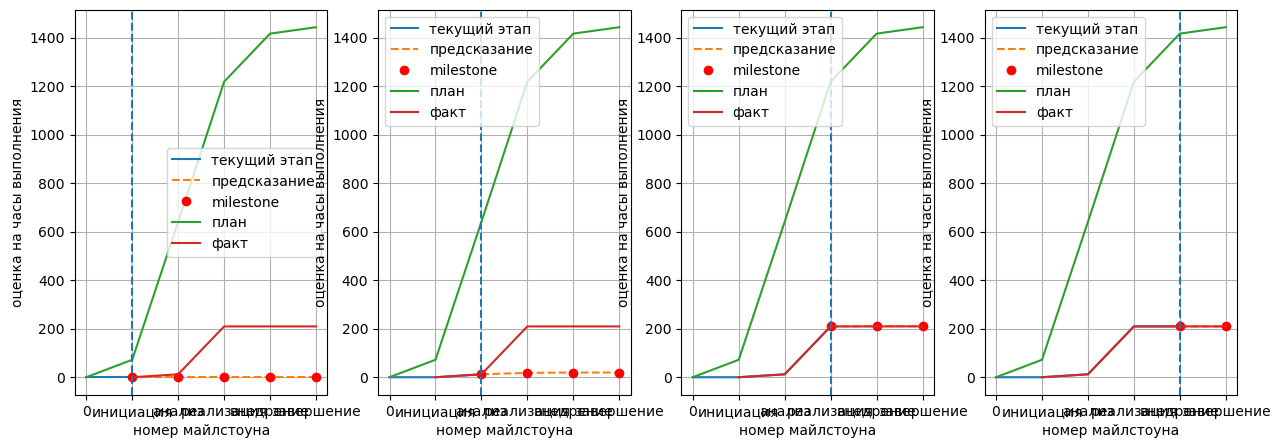

In [46]:
make_predict_chart(data_project, pos[2], first_c, second_c, third_c)

mistake: 100.0
mistake: 91.95902669684268
mistake: 20.57693275373225
mistake: 11.743686514044699


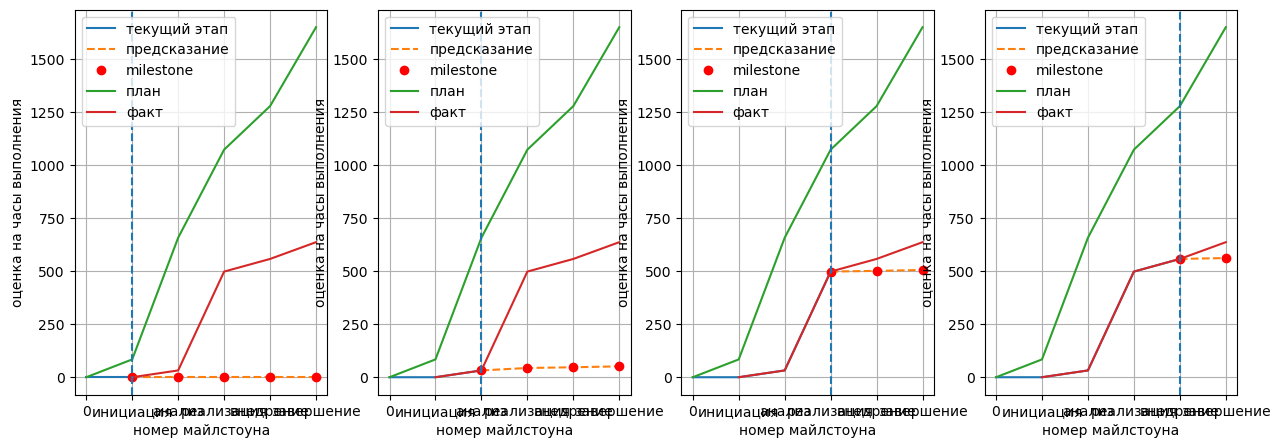

In [47]:
make_predict_chart(data_project, pos[0], first_c, second_c, third_c)